# Libraries

In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cuda


# Tunning Parameters

In [2]:
steps=20000
lr=1e-1
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
N_u = 100 #Total number of data points for 'u'
N_f = 10_000 #Total number of collocation points 
nu = 0.01/np.pi #diffusion coefficient

# Auxiliary Functions


In [ ]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def solutionplot(u_pred,X_u_train,u_train):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 0.5, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75s$', fontsize = 10)
    
    plt.savefig('Burgers-Inverse.png',dpi = 500)   

# Problem Setup
https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks

**2D Wave Equation**

$$\frac{\partial^2 p}{\partial t^2} = c^2 \left( \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} \right) \rightarrow$$
$$\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2}  - \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} = 0$$

$$x, y \in[-1,1]$$
$$t\in[0,1]$$


# Inverse Problems

**Forward Problem**: Model$→$Data (Predict)

**Inverse Problem**: Data→Model (i.e., actually, we get the Model's parameters)

###Example

(See: https://book.sciml.ai/notes/10/)

A Neural Network is an example of an inverse problem:

1.   We have an unknown model that follows:

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

2.   We use our "training" data to get $W_i$ and $b_i$; for $i=1,2,..\#layers$.


Specifically:

Data → Model i.e., estimate our model parameters (i,e., $W_i$ and $b_i$)




# PINNs for Inverse Problems or "Data-driven Discovery of Nonlinear Partial Differential Equations"

(See: https://arxiv.org/abs/1711.10566)

**Inverse Problem**: Data$→$Model's parameters so:

Data →PINN→ Model Parameters (i.e., our PDE parameters)

For parameterized and nonlinear partial differential equations of the general form (Raissi et al., 2017):

$$p_{tt}+\mathscr{N}[p; c]=0$$

where, $p(\mathbf{r},t)$ is the hidden solution and $\mathscr{N}[p;c]$ is a nonlinear operator.

In short: We will use a PINN to get $p(\mathbf{r}^{\prime},t)$ in positions $\mathbf{r}^{\prime}$.


## Analysis:

Let:

$p_{tt}=\frac{\partial^2 p}{\partial t^2}$

$p_{xx}=\frac{\partial^2 u}{\partial x^2}$
$p_{yy}=\frac{\partial^2 u}{\partial y^2}$

$\mathscr{N}[p;c]=c^2 \left( p_{xx} + p_{yy} \right)$

Our PDE is described as:

$$p_{tt} - c^2 \left( p_{xx} + p_{yy} \right)=0$$

Or,

$$p_{tt} -\mathscr{N}[p]=0$$













## Neural Network

A Neural Network is a function (See:https://book.sciml.ai/notes/03/):

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

**Note:**We usually train our N by iteratively minimizing a loss function in the training dataset(known data) to get $W_i$ and $b_i$.
 
## PINNs=Neural Network + PDE 
(See: https://www.sciencedirect.com/science/article/pii/S0021999118307125)

We can use a neural network to approximate any function (Universal APproximation Theorem): (See:https://book.sciml.ai/notes/03/)
$$N(\mathbf{r},t)\approx u(\mathbf{r},t)$$

Since N(\mathbf{r},t) is a function, we can obtain its derivatives: $\frac{\partial N}{\partial t},\frac{\partial^2 N}{\partial x^2}, etc.$.(Automatic Diferentiation)

Assume:$$N(\mathbf{r}, t)\approx p(\mathbf{r}, t)$$

Then:

$$N_{tt} - c^2 \left(N_{xx} + N_{yy} \right) \approx p_{tt} - c^2 \left(p_{xx} + p_{yy} \right)=0$$

And:

$$N_{tt} - c^2 \left(N_{xx} + N_{yy} \right)\approx 0$$


We define this function as $f$:

$$f(\mathbf{r}, t)=N_{tt} - c^2 \left(N_{xx} + N_{yy} \right)$$

Remember our operator:

$$f(\mathbf{r}, t)=N_t+\mathscr{N}[N,c]$$

So:

$$f(\mathbf{r}, t)\approx 0$$

### PINNs' Loss function

We evaluate $f$ in a certain number of points ($L$) inside our domain $(\mathbf{r},t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{L}\sum^{L}_{i=1}|f(\mathbf{r}_p^i,t_p^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, points inside our domain (i.e., interior points). **Remember that this is an inverse problem, so we know the data.**

Since we know the outcome, we select $N$ and compute the $MSE_{\mathbf{r}}$** (compare it to the reference solution).

$$MSE_{\mathbf{r}}=\frac{1}{L}\sum^{L}_{i=1}|p(\mathbf{r}_p^i, t_{p}^i)-N(\mathbf{r}_p^i, t_{p}^i)|^2$$

Please note that $\{\mathbf{r}_p^i, t_{p}^i\}_{i=1}^L$ are the same in $MSE_f$ and $MSE_{\mathbf{r}}$

#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

NOTE: We minimize $MSE$ to obtain the $N$'s parameters (i.e, $W_i$ and $b_i$) and the PDEs parameters (i.e., $p(\mathbf{r}^{\prime}, t)$)→ We will ask our neural network to find our $p(\mathbf{r}^{\prime})$.

### Neural Network

In [ ]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers, bounds):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
        self.upper_bound, self.lower_bound = bounds
        if torch.is_tensor(self.upper_bound) != True:
            self.upper_bound = torch.from_numpy(self.upper_bound)
        if torch.is_tensor(self.lower_bound) != True:
            self.lower_bound = torch.from_numpy(self.lower_bound)

        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,r):
        x, y = r
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        if torch.is_tensor(y) != True:
            y = torch.from_numpy(y)

        #preprocessing input 
        x = (x - self.lower_bound)/(self.upper_bound - self.lower_bound) #feature scaling
        y = (y - self.lower_bound)/(self.upper_bound - self.lower_bound) #feature scaling

        #convert to float
        x = x.float()
        y = y.float()

        r_processed = torch.stack((x, y), dim=-1).view(-1, 2)


        for i in range(len(layers)-2):
            
            z = self.linears[i](r_processed)
                        
            p_out = self.activation(z)
            
        p_out = self.linears[-1](p_out)
        
        return p_out

In [ ]:
#  PINN

#https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

class FCN():
    def __init__(self, layers):
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialize iterator'
        self.iter = 0
        self.c = 343.
        'Call our DNN'
        self.dnn = DNN(layers).to(device)
        'loss function'
            
    def loss_data(self,x,pm):
                
        loss_u = self.loss_function(self.dnn(x), pm)
      
        return loss_u
    
    def loss_PDE(self, X_train_Nu):
                        
        g = X_train_Nu.clone()
                        
        g.requires_grad = True
        
        pnet = self.dnn(g)
                
        p_r_t = autograd.grad(pnet,g,torch.ones([X_train_Nu.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        # u_x_t = autograd.grad(u,g,torch.ones([X_train_Nu.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]

        p_rr_tt = autograd.grad(p_r_t,g,torch.ones(X_train_Nu.shape).to(device), create_graph=True)[0]
                                                            
        # u_x = u_r_t[:,[0]]
        #
        # u_t = u_x_t[:,[1]]
        
        p_xx = p_rr_tt[:,[0]]
        p_yy = p_rr_tt[:,[1]]
        p_tt = p_rr_tt[:,[2]]

        f = p_tt - 1/self.c * (p_xx + p_yy)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x,y):

        loss_p = self.loss_data(x,y)
        loss_f = self.loss_PDE(x)
        
        loss_val = loss_p + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_train_Nu, U_train_Nu)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, _ = PINN.test()
        # TODO: FIX HERE
        #     print(
        #         'Relative Error(Test): %.5f , 𝜆_real = [1.0,  %.5f], 𝜆_PINN = [%.5f,  %.5f]' %
        #         (
        #             error_vec.cpu().detach().numpy(),
        #             nu,
        #             self.lambda1.item(),
        #             self.lambda2.item()
        #         )
        #     )
            

        return loss        
    
    'test neural network'
    def test(self):
                
        p_pred = self.dnn(X_true)
        
        error_vec = torch.linalg.norm((p_true-p_pred),2)/torch.linalg.norm(p_true,2)        # Relative L2 Norm of the error (Vector)
        
        p_pred = p_pred.cpu().detach().numpy()
        
        pu_pred = np.reshape(p_pred,(x.shape[0],t.shape[0]),order='F')
                
        return error_vec, p_pred

# Visualize data

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


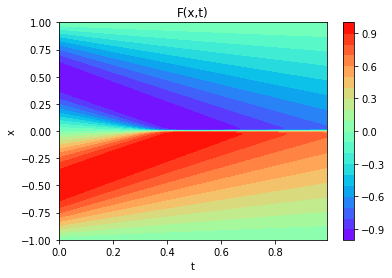

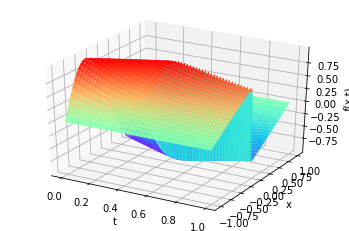

In [ ]:
data = scipy.io.loadmat('/content/gdrive/MyDrive/ScientificML/Codes/Learning/Data/Burgers.mat') 
x = data['x']                                   # 256 points between -1 and 1 [256x1]
t = data['t']                                   # 100 time points between 0 and 1 [100x1] 
usol = data['usol']                             # solution of 256x100 grid points

X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) 

In [ ]:
print(x.shape,t.shape,usol.shape)
print(X.shape,T.shape)

(256, 1) (100, 1) (256, 100)
(100, 256) (100, 256)


## Prepare Data

In [ ]:
X_true = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_true[0]  # [-1. 0.]
ub = X_true[-1] # [1.  0.99]
U_true = usol.flatten('F')[:,None] #Fortran style (Column Major)

In [ ]:
print(lb,ub)

[-1.  0.] [1.   0.99]


## Training Data

In [ ]:
total_points=len(x)*len(t)

In [ ]:
# Obtain random points for interior
id_f = np.random.choice(total_points, N_f, replace=False)# Randomly chosen points for Interior
X_train_Nu = X_true[id_f]
U_train_Nu= U_true[id_f]

In [ ]:
print("We have",total_points,"points. We will select",X_train_Nu.shape[0],"points to train our model.")


We have 25600 points. We will select 10000 points to train our model.


In [ ]:
print("Original shapes for X and U:",X.shape,usol.shape)
print("Final training data:",X_train_Nu.shape,U_train_Nu.shape)

Original shapes for X and U: (100, 256) (256, 100)
Final training data: (10000, 2) (10000, 1)


# Train Neural Network

In [ ]:
'Convert our arrays to tensors and send them to our GPU'
X_train_Nu = torch.from_numpy(X_train_Nu).float().to(device)
U_train_Nu = torch.from_numpy(U_train_Nu).float().to(device)
X_true = torch.from_numpy(X_true).float().to(device)
U_true = torch.from_numpy(U_true).float().to(device)
f_hat = torch.zeros(X_train_Nu.shape[0],1).to(device)

In [ ]:
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

In [ ]:
PINN = FCN(layers)
       
PINN

'Neural Network Summary'
print(PINN)

params = list(PINN.dnn.parameters())

'''Optimization'''

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-11, 
                              tolerance_change = 1e-11, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

start_time = time.time()

optimizer.step(PINN.closure)
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))

Relative Error(Test): 0.40038 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.10995,  0.00180]
Relative Error(Test): 0.27630 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.10895,  0.00209]
Relative Error(Test): 0.25630 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.16387,  0.00214]
Relative Error(Test): 0.22366 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.40723,  0.00628]
Relative Error(Test): 0.20818 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.48434,  0.00725]
Relative Error(Test): 0.19597 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.50651,  0.00540]
Relative Error(Test): 0.18228 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.57998,  0.00618]
Relative Error(Test): 0.17167 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.58211,  0.00498]
Relative Error(Test): 0.16647 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.57235,  0.00419]
Relative Error(Test): 0.14306 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.69912,  0.00637]
Relative Error(Test): 0.13283 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.71367,  0.00532]
Relative Error(Test): 0.12728 , 𝜆_real = [1

# Plots

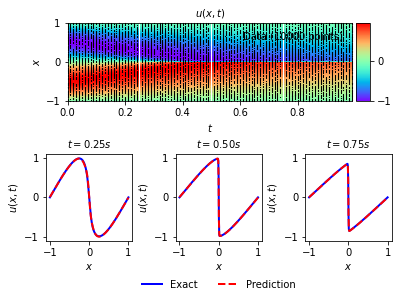

In [ ]:
solutionplot(u_pred,X_train_Nu.cpu().detach().numpy(),U_train_Nu)

In [ ]:
x1=X_true[:,0]
t1=X_true[:,1]

In [ ]:
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()

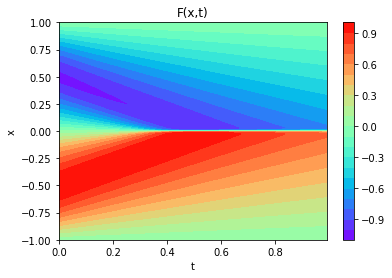

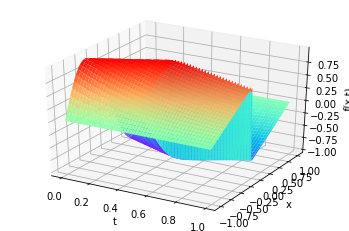

In [ ]:
plot3D_Matrix(arr_x1,arr_T1,torch.from_numpy(u_pred))

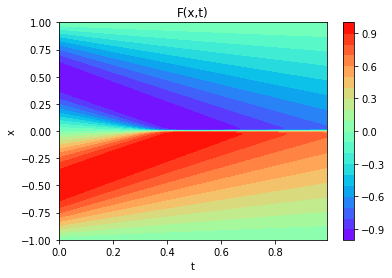

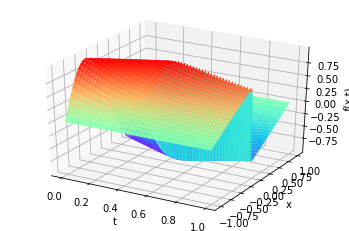

In [ ]:
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) 

## References:


[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (1907). DeepXDE: A deep learning library for solving differential equations,(2019). URL http://arxiv. org/abs/1907.04502. https://arxiv.org/abs/1907.04502

[3] Rackauckas Chris, Introduction to Scientific Machine Learning through Physics-Informed Neural Networks. https://book.sciml.ai/notes/03/

[4] Repository: Physics-Informed-Neural-Networks (PINNs).https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation

[5]  Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics Informed Deep Learning (part ii): Data-driven Discovery of Nonlinear Partial Differential Equations. arXiv preprint arXiv:1711.10566. https://arxiv.org/abs/1711.10566

[6] Repository: PPhysics-Informed Deep Learning and its Application in Computational Solid and Fluid Mechanics.https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics.

